In [1]:
from google.colab import drive
from pathlib import Path
import sys
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!rm -rf vgg16obj
!git clone -b tuning_calc https://github.com/soukhind2/vgg16obj
#! pip install https://github.com/raghakot/keras-vis/archive/master.zip

Cloning into 'vgg16obj'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 210 (delta 111), reused 99 (delta 42), pack-reused 0
Receiving objects: 100% (210/210), 2.88 MiB | 5.98 MiB/s, done.
Resolving deltas: 100% (111/111), done.


In [3]:
#!unzip -q /content/drive/My\ Drive/obj/data
#!unzip -q /content/drive/My\ Drive/obj/test2
#!unzip -q /content/drive/My\ Drive/obj/sean_test
!unzip -q /content/drive/My\ Drive/obj/data_6class

In [4]:
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt
import pickle


from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Flatten,Dense,Dropout,Input
from keras.models import Sequential,Model
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

from vgg16obj.tools import tuning_calcs as tc
from vgg16obj.tools import gradient_calcs as gc
from vgg16obj.tools import stats as st

import tensorflow as tf
from tensorflow import math

(1554, 224, 224, 3) (150, 224, 224, 3) (162, 224, 224, 3)


(-0.5, 223.5, 223.5, -0.5)

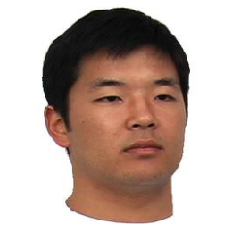

In [5]:
def convertimgs(path,data) :
    for dirName, subdir, files in os.walk(path):
        for filename in sorted(files):
            if filename == '.DS_Store':
                continue
            ds = load_img(path +'/' + filename,target_size = (224,224))
            im = img_to_array(ds)
            im /= 255.
            #im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            #im = preprocess_input(im)
            data.append(im) 
    return data


train_it = []
train_it = convertimgs('/content/data_6class/train/faces/Male',train_it)
train_it = convertimgs('/content/data_6class/train/faces/Female/',train_it)
train_it = convertimgs('/content/data_6class/train/scenes/Manmade/',train_it)
train_it = convertimgs('/content/data_6class/train/scenes/Natural/',train_it)
train_it = convertimgs('/content/data_6class/train/objects/Powered',train_it)
train_it = convertimgs('/content/data_6class/train/objects/Nonpowered',train_it)
train_it = np.array(train_it)

val_it = []
val_it = convertimgs('/content/data_6class/val/faces/Male/',val_it)
val_it = convertimgs('/content/data_6class/val/faces/Female/',val_it)
val_it = convertimgs('/content/data_6class/val/scenes/Manmade/',val_it)
val_it = convertimgs('/content/data_6class/val/scenes/Natural/',val_it)
val_it = convertimgs('/content/data_6class/val/objects/Powered',val_it)
val_it = convertimgs('/content/data_6class/val/objects/Nonpowered',val_it)
val_it = np.array(val_it)

test_it = []
test_it = convertimgs('/content/data_6class/test/faces/Male/',test_it)
test_it = convertimgs('/content/data_6class/test/faces/Female/',test_it)
test_it = convertimgs('/content/data_6class/test/scenes/Manmade/',test_it)
test_it = convertimgs('/content/data_6class/test/scenes/Natural/',test_it)
test_it = convertimgs('/content/data_6class/test/objects/Powered',test_it)
test_it = convertimgs('/content/data_6class/test/objects/Nonowered',test_it)
test_it = np.array(test_it)

print(train_it.shape,val_it.shape,test_it.shape)

plt.imshow(train_it[0])
plt.axis('off')

In [6]:
model = VGG16(weights='imagenet',
              include_top=False,input_shape = [224,224,3])
#plot_model(model,show_shapes=True,expand_nested=True)
#model.save_weights('vgg_w',save_format='h5')

58892288/58889256 [==============================] - 0s 0us/step


In [7]:
! zip -r vgg.zip vgg

	zip warning: name not matched: vgg

zip error: Nothing to do! (try: zip -r vgg.zip . -i vgg)


In [8]:
start = time.time()
features_train = model.predict(train_it) 
print(f'Train Time: {time.time() - start}')

start = time.time()
features_val = model.predict(val_it) 
print(f'Val Time: {time.time() - start}')

start = time.time()
features_test = model.predict(test_it) 
print(f'Test Time: {time.time() - start}')

     
#np.save('features_train' , features_train)
#np.save('features_val', features_val)
#np.save('features_test', features_test)

Train Time: 10.456224203109741
Val Time: 0.8642926216125488
Test Time: 0.5553607940673828


In [9]:
epochs = 30

#train_data = np.load('features_train.npy')
train_data = features_train
train_labels = to_categorical([0] * 250 + [1]*250 + [2] * 250 + [3] * 250 + [4] * 275 + [5] * 279,6)
train_labels1 = to_categorical([0] * 250 + [1]*250 + [0] * 250 + [1] * 250 + [0] * 275 + [1] * 279,2)
train_labels2 = to_categorical([0] * 250 + [0]*250 + [1] * 250 + [1] * 250 + [2] * 275 + [2] * 279,3)



#val_data = np.load('features_val.npy')
val_data = features_val
val_labels = to_categorical([0] * 25 + [1]*25 + [2] * 25 + [3] * 25 + [4] * 25 + [5] * 25,6)
val_labels1 = to_categorical([0] * 25 + [1]*25 + [0] * 25 + [1] * 25 + [0] * 25 + [1] * 25,2)
val_labels2 = to_categorical([0] * 25 + [0]*25 + [1] * 25 + [1] * 25 + [2] * 25 + [2] * 25,3)


#test_data = np.load('features_test.npy')
test_data = features_test
#test_labels = [0] * 50 + [1] * 50 + [2] * 50
#test_labels = [0] * 61 + [1] * 40 + [2] * 61
test_labels = to_categorical([0] * 31 + [1]*30 + [2] * 19 + [3] * 21 + [4] * 31 + [5] * 30,6)
test_labels1 = to_categorical([0] * 31 + [1]*30 + [0] * 19 + [1] * 21 + [0] * 31 + [1] * 30,2)
test_labels2 = to_categorical([0] * 31 + [0]*30 + [1] * 19 + [1] * 21 + [2] * 31 + [2] * 30,3)
#test_labels = to_categorical(test_labels, 3)


In [ ]:
#@title Automated Branched Model Generation
from vgg16obj.tools import objnet

model = objnet.modelarch().build_full_model([7,7,512],
                                            stem_len = [4096],
                                            b1_len = [1024],
                                            b2_len = [1024])
plot_model(model,show_shapes=True,expand_nested=True)

In [11]:

'''losses = {'branch1': 'binary_crossentropy',
          'branch2': 'categorical_crossentropy'}
'''
losses = 'categorical_crossentropy'
import tensorflow as tf


def custom_relu(x):
  return x

top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:])) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
top_model.add(Dense(6, activation='softmax',name = 'predictions'))

top_model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=['accuracy'])
top_model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = top_model.fit(x = train_data,  y = train_labels,
          epochs=epochs,
          batch_size=64,
          validation_data=(val_data, val_labels),
          verbose = 1, callbacks = [es])

#model.save_weights('top_weights',overwrite = True)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
top_dense1 (Dense)           (None, 4096)              102764544 
_________________________________________________________________
predictions (Dense)          (None, 6)                 24582     
Total params: 102,789,126
Trainable params: 102,789,126
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
25/25 [==============================] - 1s 21ms/step - loss: 0.9488 - accuracy: 0.6808 - val_loss: 0.5518 - val_accuracy: 0.7800
Epoch 2/30
25/25 [==============================] - 0s 16ms/step - loss: 0.3553 - accuracy: 0.8842 - val_loss: 0.4548 - val_accuracy: 0.7933
Epoch 3/30
25/25 [==============================] - 0s 16ms/step - loss: 0.2378 - accuracy

In [12]:
out = top_model.evaluate(test_data, test_labels)
print(out)
#print('rounded test labels',pred)

6/6 [==============================] - 0s 4ms/step - loss: 0.3661 - accuracy: 0.8457
[0.36611875891685486, 0.845678985118866]


In [13]:
#@title Branch loss plotting code
'''
lossNames = ["loss", "branch1_loss", "branch2_loss"]
plt.style.use("ggplot")
e = len(history.history['loss'])
(fig, ax) = plt.subplots(1, 3, figsize=(20, 5))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(np.arange(0, e), history.history[l], label=l)
	ax[i].plot(np.arange(0, e), history.history["val_" + l],
		label="validation_" + l)
	ax[i].legend()
'''

'\nlossNames = ["loss", "branch1_loss", "branch2_loss"]\nplt.style.use("ggplot")\ne = len(history.history[\'loss\'])\n(fig, ax) = plt.subplots(1, 3, figsize=(20, 5))\n# loop over the loss names\nfor (i, l) in enumerate(lossNames):\n\t# plot the loss for both the training and validation data\n\ttitle = "Loss for {}".format(l) if l != "loss" else "Total loss"\n\tax[i].set_title(title)\n\tax[i].set_xlabel("Epoch #")\n\tax[i].set_ylabel("Loss")\n\tax[i].plot(np.arange(0, e), history.history[l], label=l)\n\tax[i].plot(np.arange(0, e), history.history["val_" + l],\n\t\tlabel="validation_" + l)\n\tax[i].legend()\n'

Normalized confusion matrix


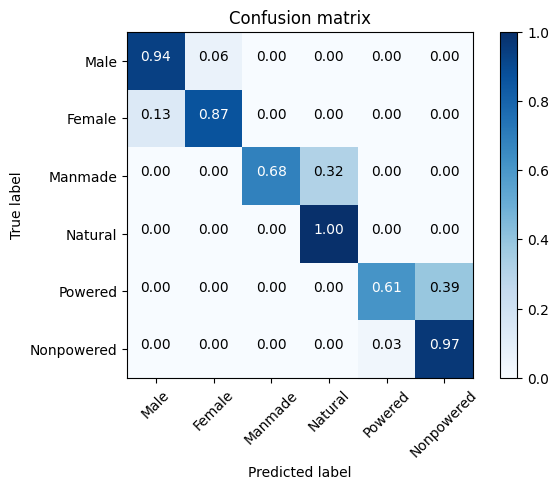

In [14]:
classes = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
#classes = ['Male/ Manmade/ Pwrd','Female/ Natural/ Nonpwrd']
#classes = ['Face', 'Scene','Tool']
plt.style.use('default')
pred = top_model.predict(test_data)
from vgg16obj.tools import plot_tools as pt
#pt.plot_metrics(history)

categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(pred).idxmax(axis=1)
cm = confusion_matrix(categorical_test_labels, categorical_preds)

pt.plot_confusion_matrix(cm,classes,normalize = True)

Feature Map Extraction/Test Run

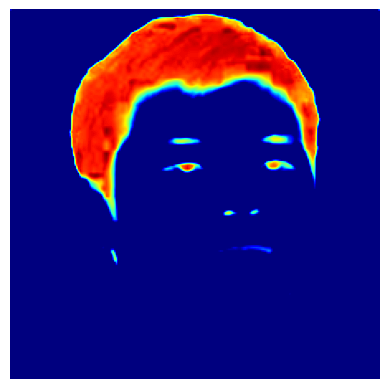

In [37]:
from keras import Model
img_tensor = train_it[0].reshape([1,224,224,3])

model = VGG16(weights='imagenet',
              include_top=False,input_shape = [224,224,3])

layer_outputs = [layer.output for layer in model.layers if 'conv1' in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

first_layer_activation = intermediate_activations[0]

plt.imshow(first_layer_activation[0, :, :, 19], cmap='jet')
plt.axis('off')
plt.show()


Calculating mean activity of feature maps in each layer

In [16]:
calc_tun_activ = 0
if calc_tun_activ:
  layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
  layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
  activation_model = Model(inputs=model.input, outputs=layer_outputs)


  start = time.time()
  tun_activ = tc.calc_tun(train_it,activation_model,layer_names)
  print(f'Elapsed: {time.time() - start}s')

  with open('tuning_values', 'wb') as fp:
      pickle.dump(tun_activ, fp)



# Tuning values

In [17]:
with open ('/content/drive/My Drive/obj/outfile', 'rb') as fp:
    tun_activ = pickle.load(fp)


### Calculation of tuning values for each map

In [18]:
ncats = 6
labels = np.array([0] * 250 + [1]*250 + [2] * 250 + [3] * 250 + [4] * 275 + [5] * 279)
cat_tun = [[[] for j in range(len(tun_activ[0]))] for i in range(ncats)]

avg_tun_activ = tc.calc_avg(tun_activ) #average tuning activity for each map
std_tun_activ = tc.calc_std(tun_activ,avg_tun_activ) #std tuning activity for each map

for i in range(ncats):
  #Calculating average activity of each
  #feature map in response to images of respective category, 
  #with the mean activity under all image categories subtracted from it
  idx = list(np.where(labels == i))
  cat_tun[i] = tc.calc_avg([tun_activ[i] for i in idx[0]])

# Vector of tuning values for each obj cataegory
fc = [[[0 for item in subl] for subl in cat_tun[0]] for i in range(ncats)]
#fc has length of ncats x nlayers x no of maps in each layer
for cat in range(ncats):
  for layer in range(len(cat_tun[cat])):
    for map in range(len(cat_tun[cat][layer])):
      if std_tun_activ[layer][map] == 0:
        continue
      fc[cat][layer][map] = (cat_tun[cat][layer][map] - 
                                avg_tun_activ[layer][map])/std_tun_activ[layer][map]


###Calculation of tuning quality for each map

In [19]:
tun_quality = tc.calc_tun_quality(fc)

### Plot tuning quality boxplots

(0.0, 100.0)

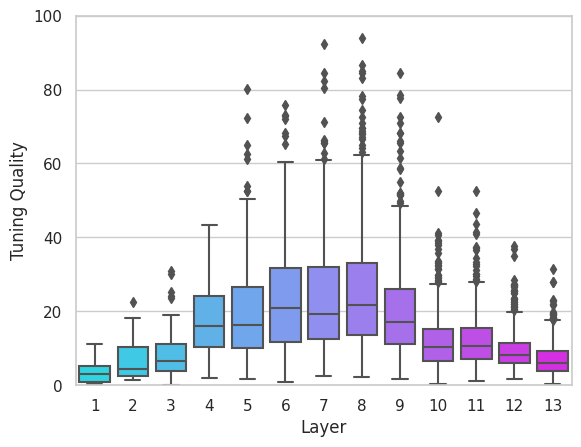

In [20]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.boxplot(data = tun_quality,palette='cool')
ax.set_xlabel('Layer')
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Tuning Quality')
ax.set_ylim([0,100])

### Plot tuning curves


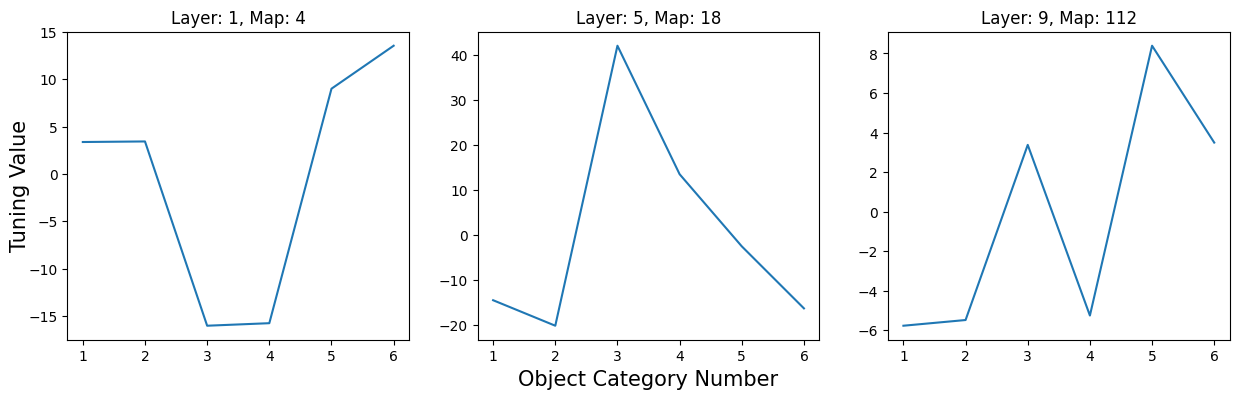

In [21]:
layers = [1,5,9]
maps = [4,18,112]
fig = pt.plot_curves(fc,layers,maps)

#Gradient Values

In [38]:
model = VGG16(weights='imagenet',
              include_top=False,input_shape = [224,224,3])

### Calculate gradient values for each map

In [23]:
calc_gradient_val = 0
if calc_gradient_val:
  layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
  cat_grads = [[[] for j in range(len(layer_names))] for i in range(ncats)]


  start = time.time()
  for i in range(ncats):
    idx = list(np.where(labels == i))
    cat_grads[i] = gc.calc_avg_gradcam(train_it[idx],model,top_model)
  print(f'Elapsed: {time.time() - start}s')

  with open('gradient_values_cat', 'wb') as fp:
      pickle.dump(cat_grads, fp)


In [24]:
with open ('/content/drive/My Drive/obj/gradient_values_cat', 'rb') as fp:
    cat_grads = pickle.load(fp)

### Simply plot the gradient curves

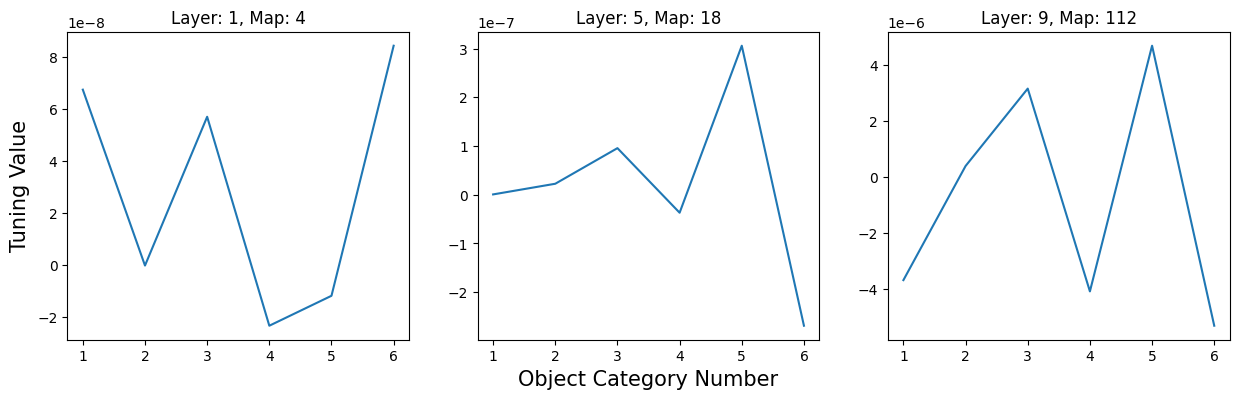

In [25]:
layers = [1,5,9]
maps = [4,18,112]
fig = pt.plot_curves(cat_grads,layers,maps)

### Double plot tuning curves and gradient curves

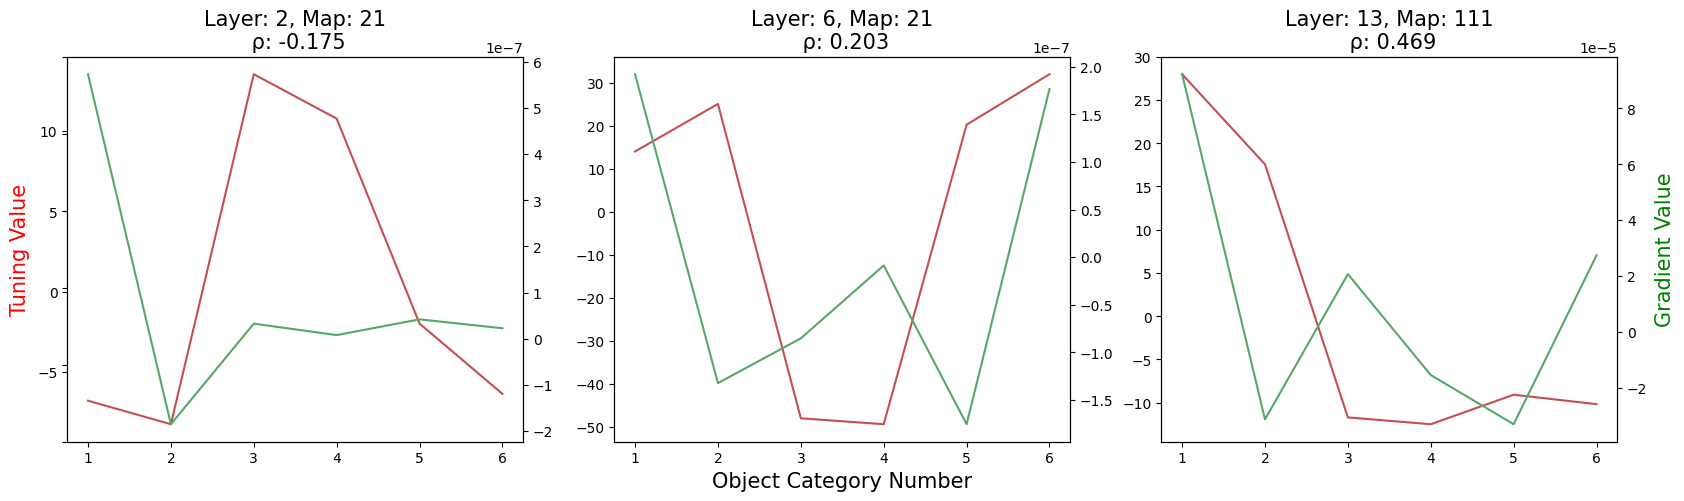

In [26]:
layers = [1,5,12]
maps = [20,20,110]
fig = pt.plot_both_curves(fc,cat_grads,layers,maps,corrcoef=True)


### Calculate correlation coefficient for each layer and map

In [27]:
corr_all = st.calc_all_corrcoeff(fc,cat_grads)

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


### Shuffle the data and recalculate correlation coefficient

In [28]:
import random

cat_grad_s = cat_grads.copy()
random.shuffle(cat_grad_s)
for cat in range(len(cat_grad_s)):
  for layer in range(len(cat_grad_s[cat])):
    random.shuffle(cat_grad_s[cat][layer])

corr_shuff = st.calc_all_corrcoeff(fc,cat_grad_s)

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


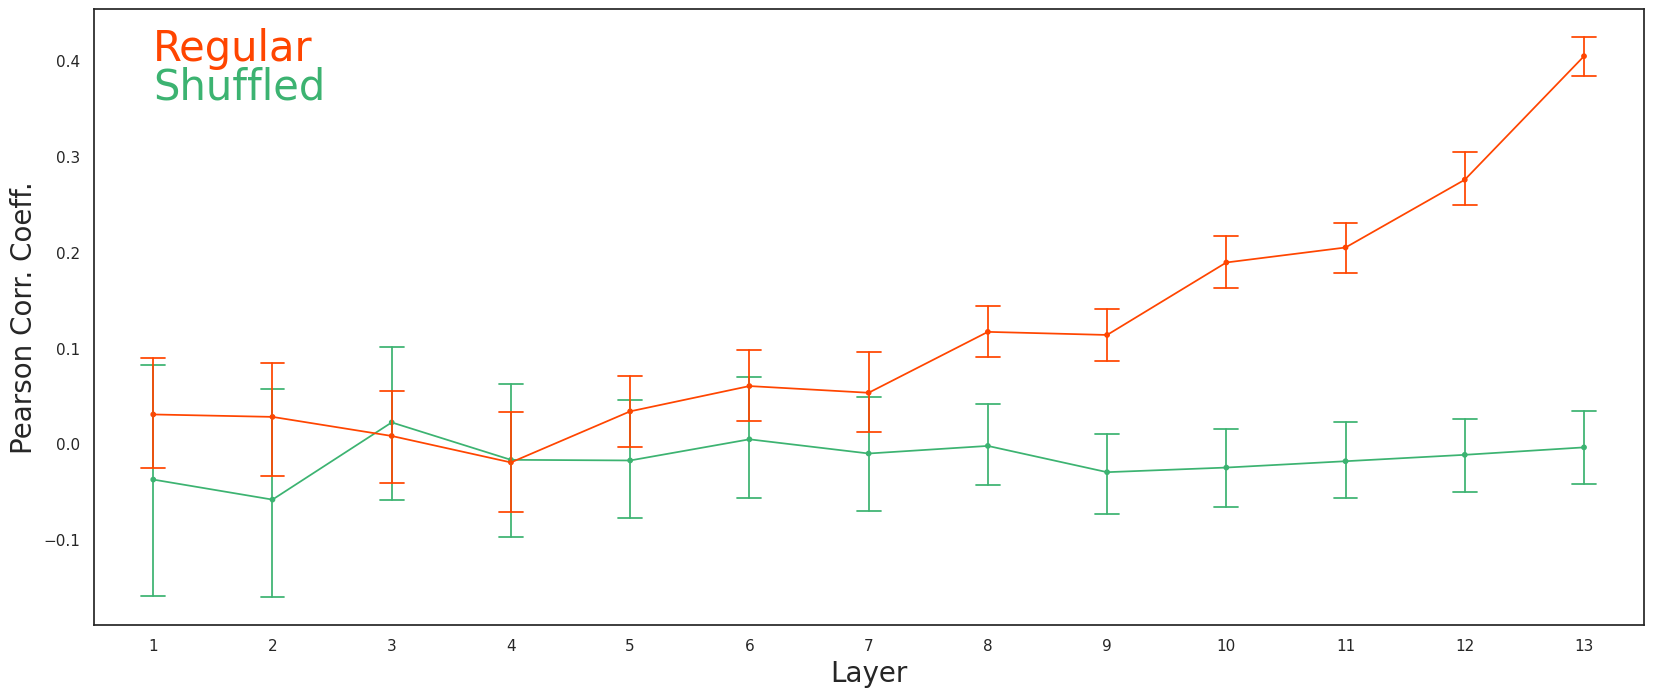

In [29]:
pt.plot_corr(corr_shuff,corr_all,figsize = (20,8))

In [ ]:
t_acc = np.zeros(13)
v_acc = np.zeros(13)
for li in range(13):
  cat = 4
  beta = [20,100,150,150,240,240,150,150,80,20,20,10,1] #multiplicative type
  layermask = [0] *13
  layermask[9] = 1
  attnmap = []
  #conv1_1 & conv1_2
  for layer in range(2):
    mapval = np.float32(cat_grads[cat][layer])
    amap = np.ones((224,224,64),dtype='float32') + np.tile(mapval,[224,224,1])* layermask[layer]
    amap[amap < 0] = 0
    attnmap.append(amap)

  #conv2_1 & conv2_2
  for layer in range(2,4):
    mapval = np.float32(cat_grads[cat][layer])
    amap = np.ones((112,112,128),dtype='float32') + np.tile(mapval,[112,112,1])* layermask[layer]
    amap[amap < 0] = 0
    attnmap.append(amap)

  #conv3_1 - conv3_3
  for layer in range(4,7):
    mapval = np.float32(cat_grads[cat][layer])
    amap = np.ones((56,56,256),dtype='float32') + np.tile(mapval,[56,56,1])* layermask[layer]
    amap[amap < 0] = 0
    attnmap.append(amap)

  #conv4_1 - conv4_3
  for layer in range(7,10):
    mapval = np.float32(cat_grads[cat][layer])
    amap = np.ones((28,28,512),dtype='float32') + np.tile(mapval,[28,28,1])* layermask[layer]
    amap[amap < 0] = 0
    attnmap.append(amap)

  #conv5_1 - conv5_3
  for layer in range(10,13):
    mapval = np.float32(cat_grads[cat][layer])
    amap = np.ones((14,14,512),dtype='float32') + np.tile(mapval,[14,14,1])* layermask[layer]
    amap[amap < 0] = 0
    attnmap.append(amap)
  #%%
  tensor_attnmap = []
  for layer in range(len(attnmap)):
    tensor_attnmap.append(tf.convert_to_tensor(attnmap[layer]))

  layeridx = 0
  from tensorflow.python.ops import nn

  def attnrelu(x,map = tensor_attnmap):
    global layeridx
    if layeridx == 13:
      layeridx = 0
    activations = math.multiply(x,map[layeridx])
    activations = nn.relu(activations)
    layeridx += 1
    return activations

  #%%
  get_custom_objects().update({'attnrelu': Activation(attnrelu)})

  for layer in model.layers:
    if(hasattr(layer,'activation')):
      layer.activation = attnrelu

  utils.apply_modifications(model)
  model.compile()

  start = time.time()
  f_train = model.predict(train_it) 
  print(f'Train Time: {time.time() - start}')

  start = time.time()
  f_val = model.predict(val_it) 
  print(f'Val Time: {time.time() - start}')

  start = time.time()
  f_test = model.predict(test_it)
  print(f'Test Time: {time.time() - start}')

  history = top_model.fit(x = f_train,  y = train_labels,
          epochs=epochs,
          batch_size=64,
          validation_data=(f_val, val_labels),
          verbose = 0, callbacks = [es])

  t_acc[li] = history.history['accuracy'][-1]
  v_acc[li] = history.history['val_accuracy'][-1]

  pred = top_model.predict(f_test)
  categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
  categorical_preds = pd.DataFrame(pred).idxmax(axis=1)
  cm = confusion_matrix(categorical_test_labels, categorical_preds)
  plt.figure()
  pt.plot_confusion_matrix(cm,classes,normalize = True)

Train Time: 5.575845718383789
Val Time: 0.5817170143127441
Test Time: 0.6143796443939209
Epoch 00003: early stopping
Normalized confusion matrix
Train Time: 5.665157079696655
Val Time: 0.5790777206420898
Test Time: 0.625053882598877
Epoch 00002: early stopping
Normalized confusion matrix
Train Time: 5.593957185745239
Val Time: 0.5853157043457031
Test Time: 0.6242258548736572
Epoch 00002: early stopping
Normalized confusion matrix
Train Time: 5.621293783187866
Val Time: 0.5739970207214355
Test Time: 0.6176421642303467


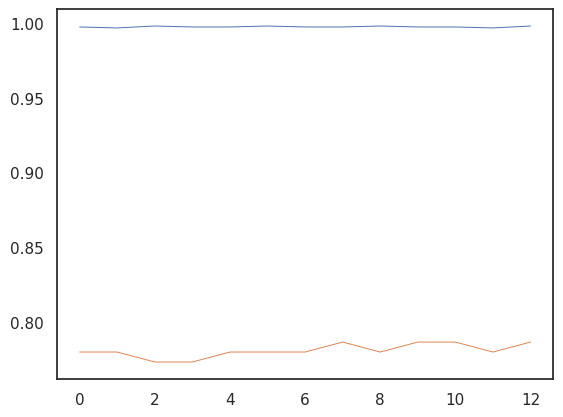

In [63]:
plt.plot(t_acc)
plt.plot(v_acc)


In [35]:
layeridx

0

In [43]:
from keras.layers import Activation
from tensorflow.keras.activations import relu
from keras.utils.generic_utils import get_custom_objects
from vis.utils import utils


get_custom_objects().update({'attnrelu': Activation(attnrelu)})

for layer in model.layers:
  if(hasattr(layer,'activation')):
    layer.activation = attnrelu

utils.apply_modifications(model)
model.compile()

start = time.time()
f_train = model.predict(train_it) 
print(f'Train Time: {time.time() - start}')

start = time.time()
f_val = model.predict(val_it) 
print(f'Val Time: {time.time() - start}')

start = time.time()
f_test = model.predict(test_it)
print(f'Test Time: {time.time() - start}')

history = top_model.fit(x = f_train,  y = train_labels,
          epochs=epochs,
          batch_size=64,
          validation_data=(f_val, val_labels),
          verbose = 0, callbacks = [es])



Train Time: 5.692055940628052
Val Time: 0.5751750469207764
Test Time: 0.616246223449707


In [53]:
history.history['accuracy'][-1]

0.9498069286346436

In [40]:
f_train[0,:,:,0]

array([[9.3033320e-01, 0.0000000e+00, 3.6362443e+00, 4.1662531e+00,
        3.3650000e+00, 0.0000000e+00, 4.6798319e-01],
       [1.5568236e+00, 2.1945148e+00, 6.9703341e+00, 8.4641714e+00,
        6.5281882e+00, 2.6812763e+00, 4.0446320e-01],
       [1.3660185e-01, 3.2241390e+00, 6.8472362e+00, 8.5820713e+00,
        5.8427148e+00, 2.0935128e+00, 0.0000000e+00],
       [0.0000000e+00, 5.4256964e+00, 6.5388107e+00, 0.0000000e+00,
        2.9867465e+00, 3.3409967e+00, 0.0000000e+00],
       [0.0000000e+00, 9.7480613e-01, 3.4556124e+00, 2.7159741e+00,
        2.8059280e+00, 3.8678489e+00, 5.4922149e-02],
       [0.0000000e+00, 0.0000000e+00, 4.6616435e+00, 1.1699925e+01,
        1.2942187e+01, 7.9639373e+00, 6.3554570e-04],
       [0.0000000e+00, 0.0000000e+00, 2.8000097e+00, 7.1979842e+00,
        6.3221936e+00, 1.4181601e+00, 0.0000000e+00]], dtype=float32)

In [45]:
losses = 'categorical_crossentropy'

top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:])) 
top_model.add(Dense(4096, activation=relu,name = 'top_dense1')) 
top_model.add(Dense(6, activation='softmax',name = 'predictions'))

top_model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=['accuracy'])
top_model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = top_model.fit(x = f_train,  y = train_labels,
          epochs=epochs,
          batch_size=64,
          validation_data=(f_val, val_labels),
          verbose = 0, callbacks = [es])



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
top_dense1 (Dense)           (None, 4096)              102764544 
_________________________________________________________________
predictions (Dense)          (None, 6)                 24582     
Total params: 102,789,126
Trainable params: 102,789,126
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
25/25 [==============================] - 0s 20ms/step - loss: 1.1434 - accuracy: 0.6030 - val_loss: 0.6994 - val_accuracy: 0.7333
Epoch 2/30
25/25 [==============================] - 0s 15ms/step - loss: 0.2948 - accuracy: 0.8835 - val_loss: 0.5144 - val_accuracy: 0.8000
Epoch 3/30
25/25 [==============================] - 0s 15ms/step - loss: 0.1464 - accura

In [52]:
history.history

{'accuracy': [0.6029601097106934, 0.8835263848304749, 0.9498069286346436],
 'loss': [1.1434444189071655, 0.2947705388069153, 0.14642620086669922],
 'val_accuracy': [0.7333333492279053, 0.800000011920929, 0.800000011920929],
 'val_loss': [0.6993991732597351, 0.5144057273864746, 0.543425977230072]}